#### Где дешевле жить? Предсказание цен в Airbnb

Основные выводы по результатам работы:
* критическое влияние в лучшую сторону на качество предсказания и снижение метрик-ошибок оказывает перевод целевой переменной (цены) в логарифмическую шкалу; т.к. исходное распределение сильно смещено в область малых значений, а логарифмированное - близко к нормальному распределению;
* высокое влияние в лучшую сторону на качество предсказания оказывает создание совмещённых между собой признаков, таких как: логарифма цены и расстояния до центра; типа комнаты и группы района города.
* умеренное влияние в лучшую сторону на качество предсказания оказывает создание новых "смысловых" признаков по существующим; например, выделение признаков по ключевым словам в названии объекта недвижимости.
* создание большого числа dummy-признаков нецелесообразно (пример: neighbourhood)
* использование StandardScaler даёт лучшие результаты, чем RobustScaler; особенно для моделей LassoCV и ElasticNetCV

Были сделаны 7 попыток разными вариантами признаков.  
Комментарии по создаваемым признакам даны перед каждой попыткой в тексте ноутбука.

Импортируем и инициализируем библиотеки и константы.

In [288]:
from math import (log, exp)

import numpy as np
import pandas as pd

from geopy.distance import geodesic

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import r2_score
from sklearn.metrics import (mean_absolute_error, root_mean_squared_error)

from sklearn.preprocessing import (OrdinalEncoder, StandardScaler, RobustScaler)

from sklearn.model_selection import train_test_split

from sklearn.linear_model import (RidgeCV, LassoCV, ElasticNetCV)

sns.set_theme()

RANDOM_SEED = 42

Загрузим датасет.

In [289]:
data = pd.read_csv('AB_NYC_2019.csv', memory_map=True)

##### 1) Exploratory Data Analysis

In [290]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48895 non-null  int64  
 1   name                            48879 non-null  object 
 2   host_id                         48895 non-null  int64  
 3   host_name                       48874 non-null  object 
 4   neighbourhood_group             48895 non-null  object 
 5   neighbourhood                   48895 non-null  object 
 6   latitude                        48895 non-null  float64
 7   longitude                       48895 non-null  float64
 8   room_type                       48895 non-null  object 
 9   price                           48895 non-null  int64  
 10  minimum_nights                  48895 non-null  int64  
 11  number_of_reviews               48895 non-null  int64  
 12  last_review                     

In [291]:
data.head(10)

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0
5,5099,Large Cozy 1 BR Apartment In Midtown East,7322,Chris,Manhattan,Murray Hill,40.74767,-73.97500,Entire home/apt,200,3,74,2019-06-22,0.59,1,129
6,5121,BlissArtsSpace!,7356,Garon,Brooklyn,Bedford-Stuyvesant,40.68688,-73.95596,Private room,60,45,49,2017-10-05,0.40,1,0
7,5178,Large Furnished Room Near B'way,8967,Shunichi,Manhattan,Hell's Kitchen,40.76489,-73.98493,Private room,79,2,430,2019-06-24,3.47,1,220
8,5203,Cozy Clean Guest Room - Family Apt,7490,MaryEllen,Manhattan,Upper West Side,40.80178,-73.96723,Private room,79,2,118,2017-07-21,0.99,1,0
9,5238,Cute & Cozy Lower East Side 1 bdrm,7549,Ben,Manhattan,Chinatown,40.71344,-73.99037,Entire home/apt,150,1,160,2019-06-09,1.33,4,188


Удалим ненужные признаки: 'id', 'host_id', 'host_name'.

In [292]:
data.drop(['id', 'host_id', 'host_name'], axis=1, inplace=True, errors='ignore')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   name                            48879 non-null  object 
 1   neighbourhood_group             48895 non-null  object 
 2   neighbourhood                   48895 non-null  object 
 3   latitude                        48895 non-null  float64
 4   longitude                       48895 non-null  float64
 5   room_type                       48895 non-null  object 
 6   price                           48895 non-null  int64  
 7   minimum_nights                  48895 non-null  int64  
 8   number_of_reviews               48895 non-null  int64  
 9   last_review                     38843 non-null  object 
 10  reviews_per_month               38843 non-null  float64
 11  calculated_host_listings_count  48895 non-null  int64  
 12  availability_365                

Типы данных колонок соответствую смыслу данных, хранящихся в них.

Посмотрим общую информацию о датасете:

In [293]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   name                            48879 non-null  object 
 1   neighbourhood_group             48895 non-null  object 
 2   neighbourhood                   48895 non-null  object 
 3   latitude                        48895 non-null  float64
 4   longitude                       48895 non-null  float64
 5   room_type                       48895 non-null  object 
 6   price                           48895 non-null  int64  
 7   minimum_nights                  48895 non-null  int64  
 8   number_of_reviews               48895 non-null  int64  
 9   last_review                     38843 non-null  object 
 10  reviews_per_month               38843 non-null  float64
 11  calculated_host_listings_count  48895 non-null  int64  
 12  availability_365                

Процент пропущенных данных:

In [294]:
100*data.isna().sum()/data.count()

name                               0.032734
neighbourhood_group                0.000000
neighbourhood                      0.000000
latitude                           0.000000
longitude                          0.000000
room_type                          0.000000
price                              0.000000
minimum_nights                     0.000000
number_of_reviews                  0.000000
last_review                       25.878537
reviews_per_month                 25.878537
calculated_host_listings_count     0.000000
availability_365                   0.000000
dtype: float64

Основные статистики:

In [295]:
data.describe(percentiles=[0.68, 0.95, 0.997])      # возмём перцентили по правилу "трёх сигм"

,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,38843.000000,48895.000000,48895.000000
mean,40.728949,-73.952170,152.720687,7.029962,23.274466,1.373221,7.143982,112.781327
std,0.054530,0.046157,240.154170,20.510550,44.550582,1.680442,32.952519,131.622289
min,40.499790,-74.244420,0.000000,1.000000,0.000000,0.010000,1.000000,0.000000
50%,40.723070,-73.955680,106.000000,3.000000,5.000000,0.720000,1.000000,45.000000
68%,40.752370,-73.942750,150.000000,4.000000,15.000000,1.550000,2.000000,168.000000
95%,40.825643,-73.865771,355.000000,30.000000,114.000000,4.640000,15.000000,359.000000
99.7%,40.881831,-73.745164,1500.000000,120.000000,292.000000,9.410000,327.000000,365.000000
max,40.913060,-73.712990,10000.000000,1250.000000,629.000000,58.500000,327.000000,365.000000


Видно, что выбросы (сравнивая 99.7% перцентиль и max) есть у признаков `price`, `minimum_nights`, `number_of_reviews`, `reviews_per_month`.

В принципе, записи датасета с выбросами в признаках `price`, `minimum_nights` можно было бы удалить, т.к. они отражают крайне редкие "лоты", слабо влияющие на общую картину. Записи с выбросами в признаках `number_of_reviews`, `reviews_per_month` я бы оставил, т.к. они всё-таки отражают ценность объекта недвижимости.

In [296]:
PRICE_99_7_PCT = 1500
data[data['price'] > PRICE_99_7_PCT]

,name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
496,Luxury 2Bed/2.5Bath Central Park View,Manhattan,Upper West Side,40.77350,-73.98697,Entire home/apt,2000,30,30,2018-05-05,0.33,11,0
946,Beautiful 3 bedroom in Manhattan,Manhattan,Upper West Side,40.80142,-73.96931,Private room,3000,7,0,NaN,NaN,1,365
1480,Lux 2Bed/2.5Bath Central Park Views,Manhattan,Upper West Side,40.77516,-73.98573,Entire home/apt,2000,30,59,2016-01-28,0.71,11,364
1862,"Sunny, Family-Friendly 2 Bedroom",Brooklyn,Prospect Heights,40.67919,-73.97191,Entire home/apt,4000,4,0,NaN,NaN,1,83
2018,Architecturally Stunning Former Synagogue!,Manhattan,East Village,40.72668,-73.98179,Entire home/apt,2500,30,15,2019-07-01,0.26,1,89
...,...,...,...,...,...,...,...,...,...,...,...,...,...
47869,Private Townhome in Midtown East near UN,Manhattan,Midtown,40.75420,-73.96815,Entire home/apt,1600,3,0,NaN,NaN,1,365
48043,Luxury TriBeCa Apartment at an amazing price,Manhattan,Tribeca,40.71206,-74.00999,Entire home/apt,6500,180,0,NaN,NaN,1,365
48304,Next to Times Square/Javits/MSG! Amazing 1BR!,Manhattan,Hell's Kitchen,40.75533,-73.99866,Entire home/apt,2999,30,0,NaN,NaN,1,222
48305,2BR Near Museum Mile! Upper East Side!,Manhattan,Upper East Side,40.78132,-73.95262,Entire home/apt,1999,30,0,NaN,NaN,1,270


In [297]:
data.drop(index=data[data['price'] > PRICE_99_7_PCT].index, inplace=True)

In [298]:
MINIMUM_NIGHTS_99_7_PCT = 120
data[data['minimum_nights'] > MINIMUM_NIGHTS_99_7_PCT]

,name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
61,Sunny & Spacious Chelsea Apartment,Manhattan,Chelsea,40.74623,-73.99530,Entire home/apt,375,180,5,2018-11-03,0.12,1,180
245,"Quiet, clean midtown apt w. elevato",Manhattan,Midtown,40.75749,-73.96897,Entire home/apt,110,200,92,2019-04-30,0.90,1,140
700,CHELSEA 1 Bdrm Plus Sleeping Loft!!,Manhattan,Chelsea,40.74618,-74.00392,Entire home/apt,195,365,10,2014-10-26,0.12,1,0
719,Prime Williamsburg 1/BD New Condo,Brooklyn,Williamsburg,40.72059,-73.95670,Entire home/apt,185,180,24,2015-08-19,0.26,1,0
754,"Easy, comfortable studio in Midtown",Manhattan,Midtown,40.75282,-73.97315,Entire home/apt,125,365,19,2015-09-08,0.21,1,365
...,...,...,...,...,...,...,...,...,...,...,...,...,...
44070,Prime Gramercy! **12 months lease!,Manhattan,Kips Bay,40.73859,-73.98218,Entire home/apt,89,360,0,NaN,NaN,4,364
44736,The BEAUTY & the EAST/free street parking & WIFI,Manhattan,East Village,40.73070,-73.98299,Entire home/apt,120,365,4,2019-05-17,1.90,5,305
47620,Williamsburg Apartment,Brooklyn,Williamsburg,40.70898,-73.94885,Entire home/apt,140,500,0,NaN,NaN,1,331
48205,Room with Amazing location in Manhattan,Manhattan,East Harlem,40.78774,-73.94627,Private room,73,180,0,NaN,NaN,1,0


In [299]:
data.drop(index=data[data['minimum_nights'] > MINIMUM_NIGHTS_99_7_PCT].index, inplace=True)

In [300]:
data.pivot_table(index=['neighbourhood_group'], values=['price'], aggfunc=['median', 'min', 'max'])

,median,min,max
,price,price,price
neighbourhood_group,,,
Bronx,65.0,0,1000
Brooklyn,90.0,0,1500
Manhattan,150.0,0,1500
Queens,75.0,10,1500
Staten Island,75.0,13,1250


In [301]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 48622 entries, 0 to 48894
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   name                            48607 non-null  object 
 1   neighbourhood_group             48622 non-null  object 
 2   neighbourhood                   48622 non-null  object 
 3   latitude                        48622 non-null  float64
 4   longitude                       48622 non-null  float64
 5   room_type                       48622 non-null  object 
 6   price                           48622 non-null  int64  
 7   minimum_nights                  48622 non-null  int64  
 8   number_of_reviews               48622 non-null  int64  
 9   last_review                     38713 non-null  object 
 10  reviews_per_month               38713 non-null  float64
 11  calculated_host_listings_count  48622 non-null  int64  
 12  availability_365                48622

In [302]:
data.head(10)

,name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,Clean & quiet apt home by the park,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,Skylit Midtown Castle,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,THE VILLAGE OF HARLEM....NEW YORK !,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,Cozy Entire Floor of Brownstone,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,Entire Apt: Spacious Studio/Loft by central park,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0
5,Large Cozy 1 BR Apartment In Midtown East,Manhattan,Murray Hill,40.74767,-73.97500,Entire home/apt,200,3,74,2019-06-22,0.59,1,129
6,BlissArtsSpace!,Brooklyn,Bedford-Stuyvesant,40.68688,-73.95596,Private room,60,45,49,2017-10-05,0.40,1,0
7,Large Furnished Room Near B'way,Manhattan,Hell's Kitchen,40.76489,-73.98493,Private room,79,2,430,2019-06-24,3.47,1,220
8,Cozy Clean Guest Room - Family Apt,Manhattan,Upper West Side,40.80178,-73.96723,Private room,79,2,118,2017-07-21,0.99,1,0
9,Cute & Cozy Lower East Side 1 bdrm,Manhattan,Chinatown,40.71344,-73.99037,Entire home/apt,150,1,160,2019-06-09,1.33,4,188


В датасете в колонке `reviews_per_month` пропущено более 25% данных. `reviews_per_month` - количество просмотров объекта в месяц. Если просмотров не было (когда значение `NaN`), значение колонки можно принять за `0`.  
Создадим признак `had_no_reviews`, чтобы сохранить факты отсутствия обзора.

In [303]:
data['had_no_reviews'] = data['reviews_per_month'].isna()
data.fillna({ 'reviews_per_month': 0 }, inplace=True)
data.isna().sum()

name                                15
neighbourhood_group                  0
neighbourhood                        0
latitude                             0
longitude                            0
room_type                            0
price                                0
minimum_nights                       0
number_of_reviews                    0
last_review                       9909
reviews_per_month                    0
calculated_host_listings_count       0
availability_365                     0
had_no_reviews                       0
dtype: int64

In [304]:
data['had_no_reviews'].unique()

array([False,  True])

Поскольку цель задания - предсказание цен на проживание, то целевая переменная - это стоимость проживания `price`.  
Так как целевая переменная целочисленного типа, при предсказании будем решать задачу регрессии.

Визуализируем распределение признаков:

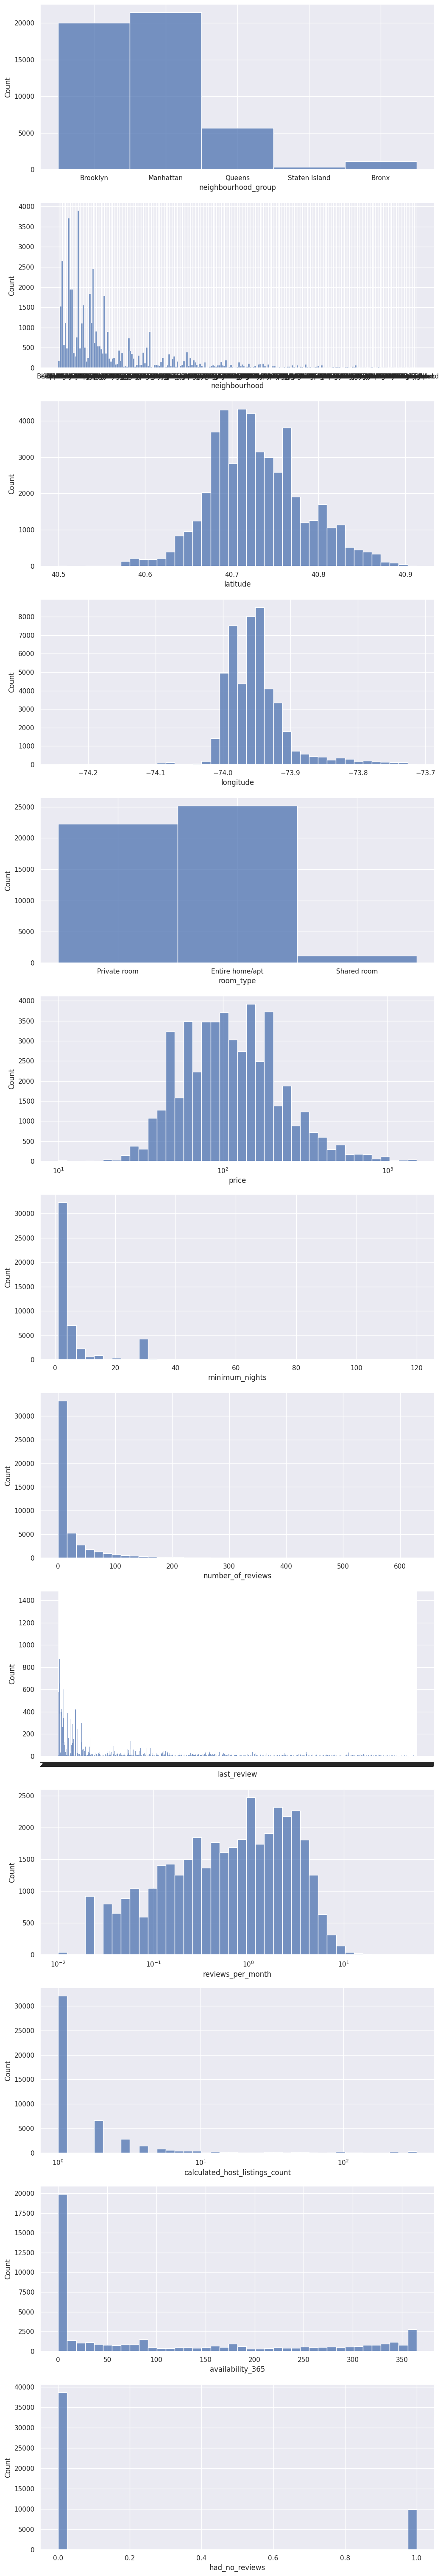

In [305]:
viz = data.drop('name', axis=1)

n_cols = 1
n_rows = len(viz.columns)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 6*n_rows))

for i, c in enumerate(viz.columns):
    sns.histplot(data=viz, x=c, bins=40, ax=axes[i], log_scale=(c in ('price', 'reviews_per_month', 'calculated_host_listings_count')))
plt.show()

Построим и визуализируем матрицу корреляций:

In [306]:
correlation_matrix = data.corr(numeric_only=True)
correlation_matrix

,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,had_no_reviews
latitude,1.000000,0.084679,0.058497,0.041607,-0.015166,-0.018399,0.019568,-0.011791,0.029557
longitude,0.084679,1.000000,-0.246549,-0.095120,0.058438,0.137609,-0.115235,0.085122,-0.041859
price,0.058497,-0.246549,1.000000,0.031349,-0.059168,-0.058984,0.117621,0.115719,0.098228
minimum_nights,0.041607,-0.095120,0.031349,1.000000,-0.134277,-0.204593,0.264530,0.213880,0.168940
number_of_reviews,-0.015166,0.058438,-0.059168,-0.134277,1.000000,0.588919,-0.072722,0.175068,-0.264932
reviews_per_month,-0.018399,0.137609,-0.058984,-0.204593,0.588919,1.000000,-0.047741,0.167006,-0.346495
calculated_host_listings_count,0.019568,-0.115235,0.117621,0.264530,-0.072722,-0.047741,1.000000,0.227256,0.119399
availability_365,-0.011791,0.085122,0.115719,0.213880,0.175068,0.167006,0.227256,1.000000,-0.035086
had_no_reviews,0.029557,-0.041859,0.098228,0.168940,-0.264932,-0.346495,0.119399,-0.035086,1.000000


<Axes: >

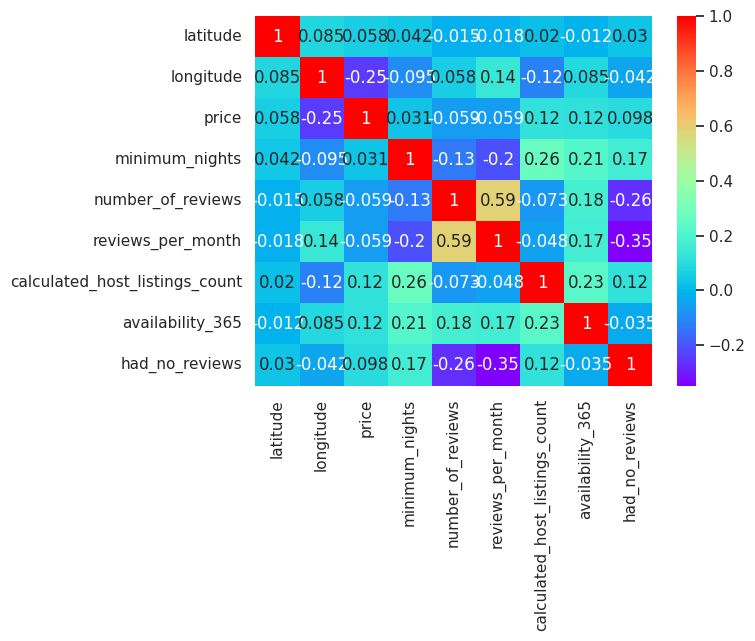

In [307]:
sns.heatmap(correlation_matrix, annot=True, cmap='rainbow')

Сильно скоррелированными являются признаки `reviews_per_month` и `number_of_reviews`.

Используем стратегию feature removal для уменьшения размерности данных и устранения мультиколлинеарности.
Рассмотрим скоррелированные признаки `reviews_per_month` и `number_of_reviews` в разрезе корреляции с целевой переменной `price`.

Корреляция `number_of_reviews` и `price` $-0.048$.

Корреляция `reviews_per_month` и `price` $-0.051$. Удалим `number_of_reviews`, как признак с более сильной корреляцией.

In [308]:
data.drop(['number_of_reviews'], axis=1, inplace=True, errors='ignore')
data.head(10)

,name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,last_review,reviews_per_month,calculated_host_listings_count,availability_365,had_no_reviews
0,Clean & quiet apt home by the park,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,2018-10-19,0.21,6,365,False
1,Skylit Midtown Castle,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,2019-05-21,0.38,2,355,False
2,THE VILLAGE OF HARLEM....NEW YORK !,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,NaN,0.00,1,365,True
3,Cozy Entire Floor of Brownstone,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,2019-07-05,4.64,1,194,False
4,Entire Apt: Spacious Studio/Loft by central park,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,2018-11-19,0.10,1,0,False
5,Large Cozy 1 BR Apartment In Midtown East,Manhattan,Murray Hill,40.74767,-73.97500,Entire home/apt,200,3,2019-06-22,0.59,1,129,False
6,BlissArtsSpace!,Brooklyn,Bedford-Stuyvesant,40.68688,-73.95596,Private room,60,45,2017-10-05,0.40,1,0,False
7,Large Furnished Room Near B'way,Manhattan,Hell's Kitchen,40.76489,-73.98493,Private room,79,2,2019-06-24,3.47,1,220,False
8,Cozy Clean Guest Room - Family Apt,Manhattan,Upper West Side,40.80178,-73.96723,Private room,79,2,2017-07-21,0.99,1,0,False
9,Cute & Cozy Lower East Side 1 bdrm,Manhattan,Chinatown,40.71344,-73.99037,Entire home/apt,150,1,2019-06-09,1.33,4,188,False


Построим парные диаграммы рассеяния.

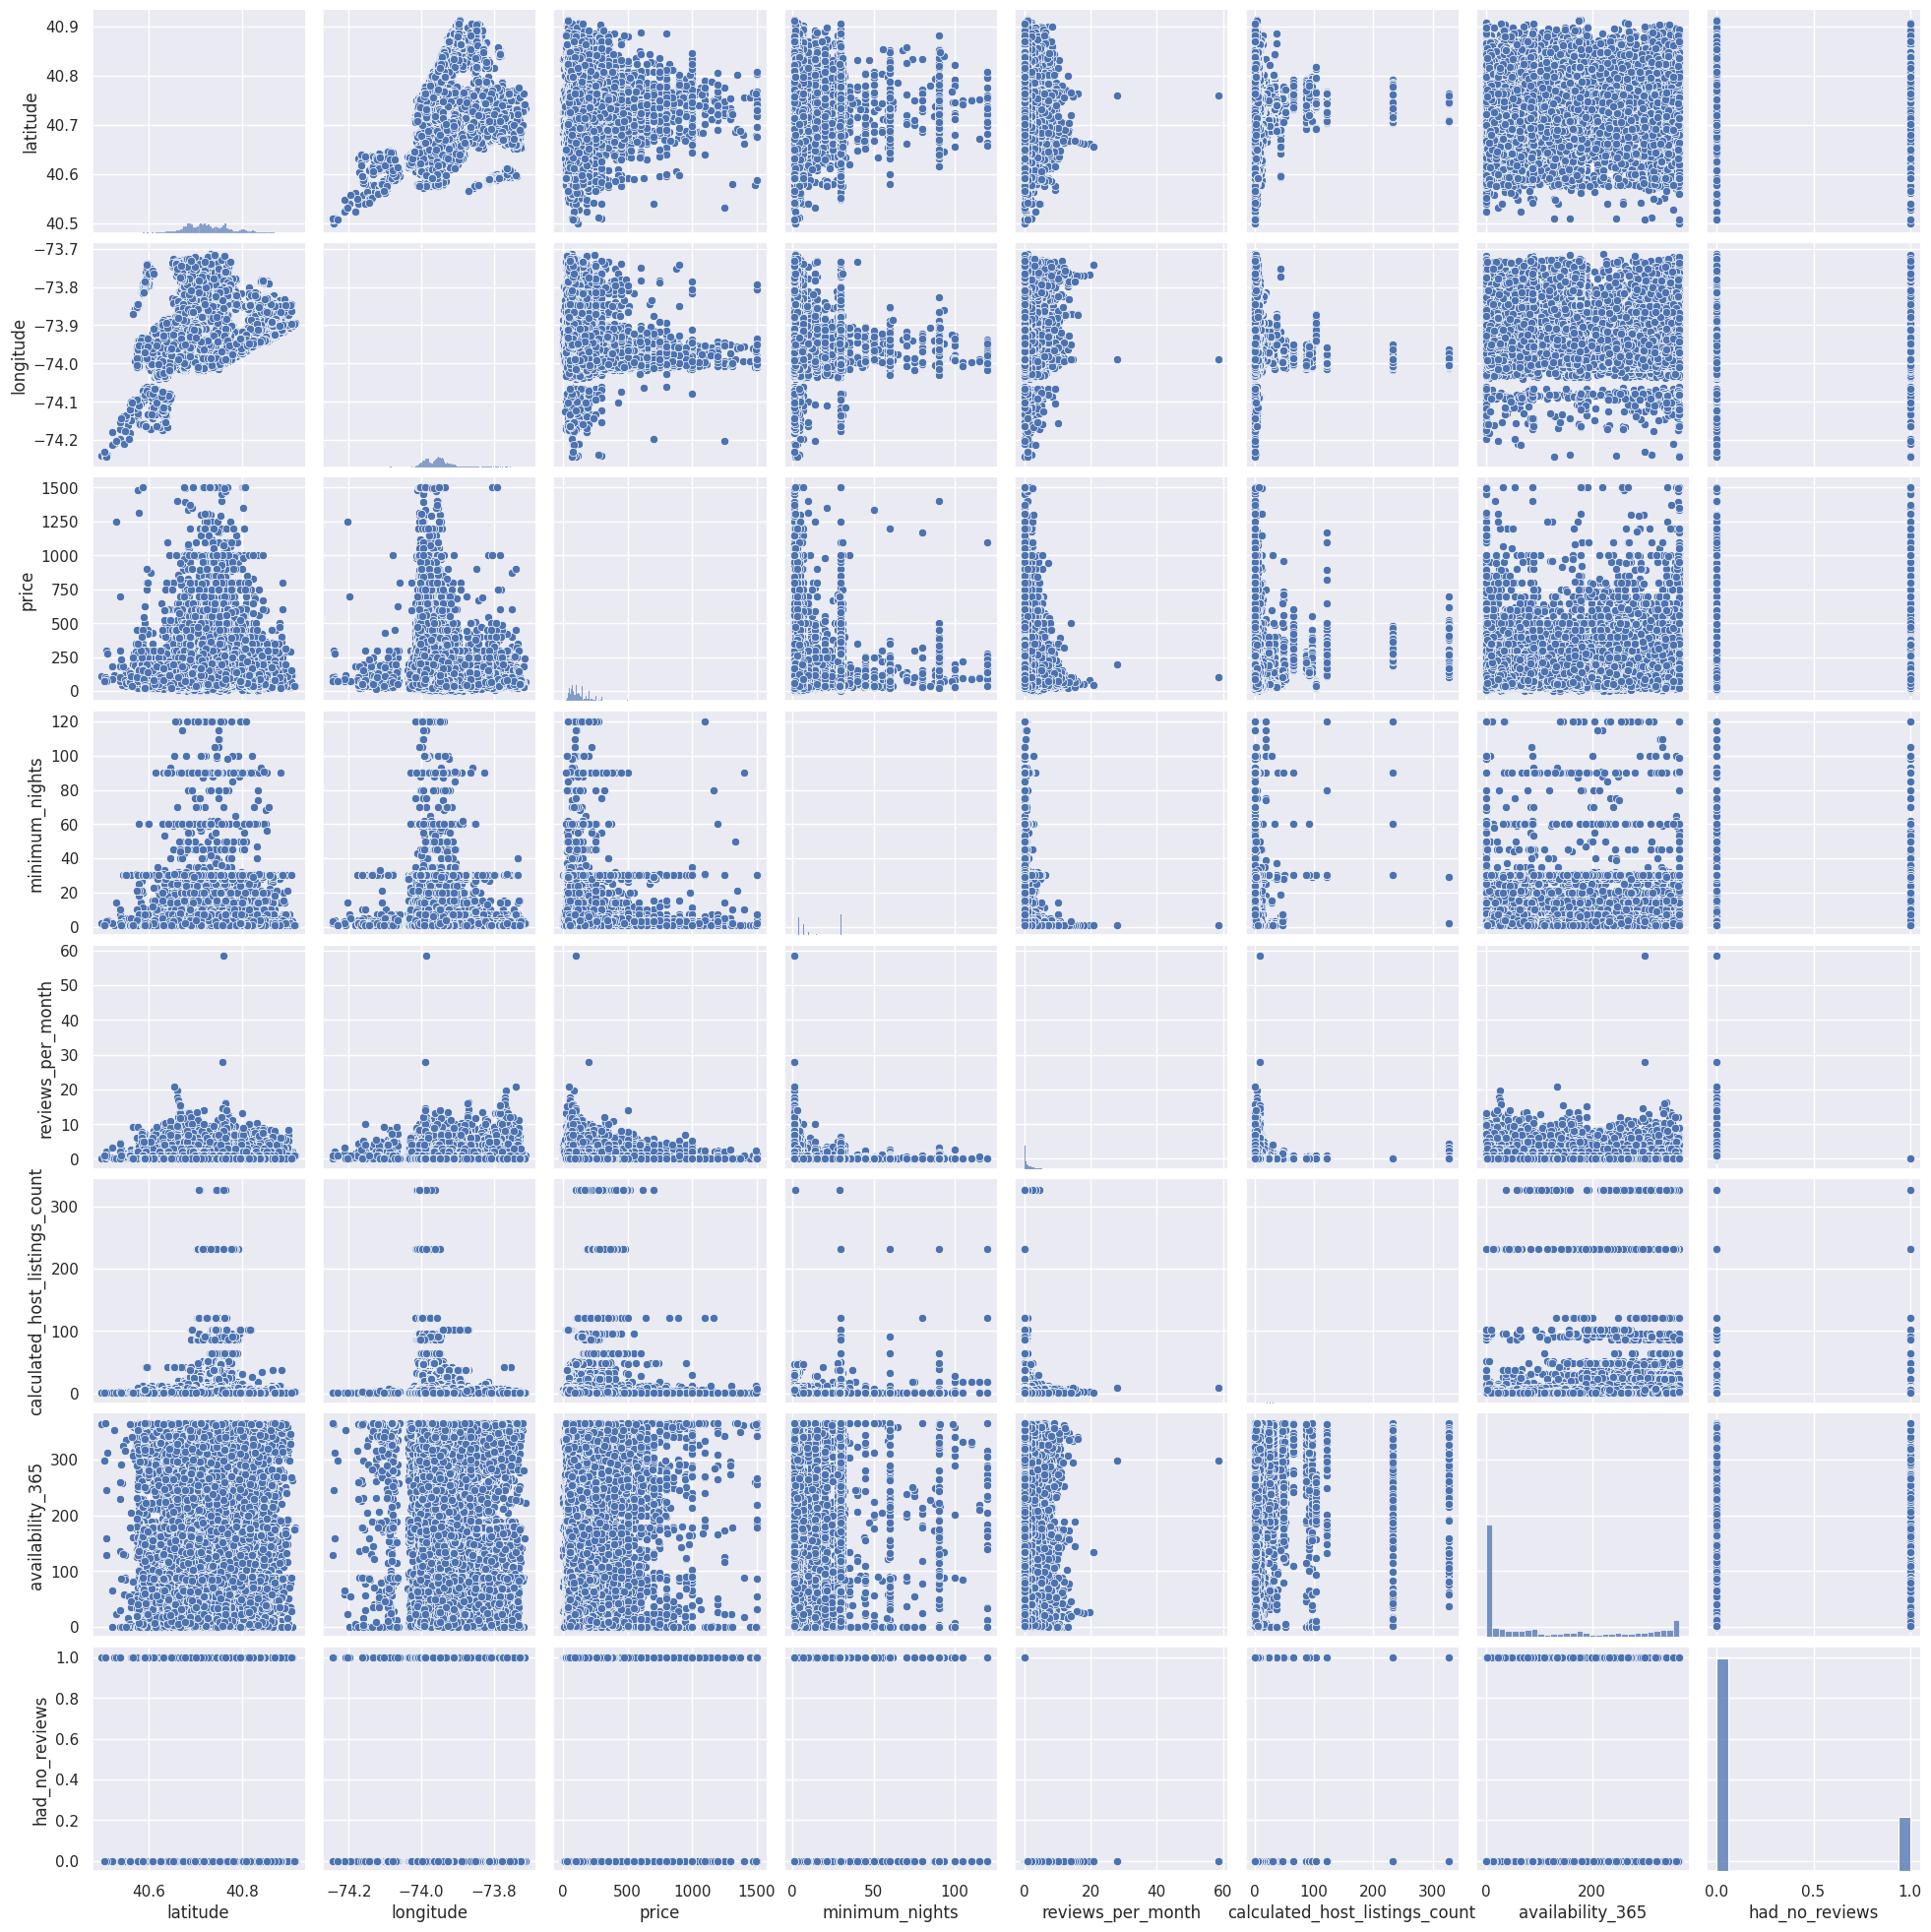

In [309]:
sns.pairplot(data)

##### 2) Preprocessing & Feature Engineering

Подготовим функцию для оценки качества предсказания модели регрессии:

In [310]:
def estimate_quality(ds_true, ds_pred) -> dict:
    r2 = r2_score(ds_true, ds_pred)
    mae = mean_absolute_error(ds_true, ds_pred)
    rmse = root_mean_squared_error(ds_true, ds_pred)
    return {
        "R2": r2,
        "MAE": mae,
        "RMSE": rmse
    }

Подготовим функцию для предсказаний по выбранным моделям:

In [311]:
def models_predict(scaler, data) -> pd.DataFrame:
    X = data.drop(['name', 'price'], axis=1)
    y = data['price']
    
    X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RANDOM_SEED)

    ridge = RidgeCV()
    ridge.fit(X_train, y_train)

    lasso = LassoCV()
    lasso.fit(X_train, y_train)

    elasticNet = ElasticNetCV()
    elasticNet.fit(X_train, y_train)

    return pd.DataFrame({
        ridge.__class__.__name__: estimate_quality(y_test, ridge.predict(X_test)),
        lasso.__class__.__name__: estimate_quality(y_test, lasso.predict(X_test)),
        elasticNet.__class__.__name__: estimate_quality(y_test, elasticNet.predict(X_test))
    })

In [312]:
len(data['neighbourhood'].unique())

221

In [313]:
data['neighbourhood'].unique()

array(['Kensington', 'Midtown', 'Harlem', 'Clinton Hill', 'East Harlem',
       'Murray Hill', 'Bedford-Stuyvesant', "Hell's Kitchen",
       'Upper West Side', 'Chinatown', 'South Slope', 'West Village',
       'Williamsburg', 'Fort Greene', 'Chelsea', 'Crown Heights',
       'Park Slope', 'Windsor Terrace', 'Inwood', 'East Village',
       'Greenpoint', 'Bushwick', 'Flatbush', 'Lower East Side',
       'Prospect-Lefferts Gardens', 'Long Island City', 'Kips Bay',
       'SoHo', 'Upper East Side', 'Prospect Heights',
       'Washington Heights', 'Woodside', 'Brooklyn Heights',
       'Carroll Gardens', 'Gowanus', 'Flatlands', 'Cobble Hill',
       'Flushing', 'Boerum Hill', 'Sunnyside', 'DUMBO', 'St. George',
       'Highbridge', 'Financial District', 'Ridgewood',
       'Morningside Heights', 'Jamaica', 'Middle Village', 'NoHo',
       'Ditmars Steinway', 'Flatiron District', 'Roosevelt Island',
       'Greenwich Village', 'Little Italy', 'East Flatbush',
       'Tompkinsville', 'Asto

In [314]:
data['neighbourhood_group'].unique()

array(['Brooklyn', 'Manhattan', 'Queens', 'Staten Island', 'Bronx'],
      dtype=object)

In [315]:
data['room_type'].unique()

array(['Private room', 'Entire home/apt', 'Shared room'], dtype=object)

In [316]:
data.loc[data['room_type'] == 'Private room', 'room_type'] = 'PRIVATE'
data.loc[data['room_type'] == 'Entire home/apt', 'room_type'] = 'ENTIRE'
data.loc[data['room_type'] == 'Shared room', 'room_type'] = 'SHARED'

In [317]:
data['room_type'].unique()

array(['PRIVATE', 'ENTIRE', 'SHARED'], dtype=object)

Поработаем с полем `last_review`

In [318]:
data['last_review'].astype('datetime64[s]').min(), \
data['last_review'].astype('datetime64[s]').max(), \
data['last_review'].isna().sum()

(Timestamp('2011-03-28 00:00:00'),
 Timestamp('2019-07-08 00:00:00'),
 np.int64(9909))

Заполним пропуски условным значением "далеко в прошлом".  
Сгенерируем новый признак, обозначающий "свежесть" обзора объекта: количество дней с последнего обзора.

In [319]:
MIN_LAST_REVIEW = '2000-01-01'
MAX_LAST_REVIEW = data['last_review'].astype('datetime64[s]').max()

data.loc[data['last_review'].isna(), 'last_review'] = MIN_LAST_REVIEW
data['days_from_last_review'] = data['last_review'].astype('datetime64[s]').apply(lambda d: (MAX_LAST_REVIEW - d).days)

data.drop(['last_review'], axis=1, inplace=True, errors='ignore')
data.head(10)

,name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,reviews_per_month,calculated_host_listings_count,availability_365,had_no_reviews,days_from_last_review
0,Clean & quiet apt home by the park,Brooklyn,Kensington,40.64749,-73.97237,PRIVATE,149,1,0.21,6,365,False,262
1,Skylit Midtown Castle,Manhattan,Midtown,40.75362,-73.98377,ENTIRE,225,1,0.38,2,355,False,48
2,THE VILLAGE OF HARLEM....NEW YORK !,Manhattan,Harlem,40.80902,-73.94190,PRIVATE,150,3,0.00,1,365,True,7128
3,Cozy Entire Floor of Brownstone,Brooklyn,Clinton Hill,40.68514,-73.95976,ENTIRE,89,1,4.64,1,194,False,3
4,Entire Apt: Spacious Studio/Loft by central park,Manhattan,East Harlem,40.79851,-73.94399,ENTIRE,80,10,0.10,1,0,False,231
5,Large Cozy 1 BR Apartment In Midtown East,Manhattan,Murray Hill,40.74767,-73.97500,ENTIRE,200,3,0.59,1,129,False,16
6,BlissArtsSpace!,Brooklyn,Bedford-Stuyvesant,40.68688,-73.95596,PRIVATE,60,45,0.40,1,0,False,641
7,Large Furnished Room Near B'way,Manhattan,Hell's Kitchen,40.76489,-73.98493,PRIVATE,79,2,3.47,1,220,False,14
8,Cozy Clean Guest Room - Family Apt,Manhattan,Upper West Side,40.80178,-73.96723,PRIVATE,79,2,0.99,1,0,False,717
9,Cute & Cozy Lower East Side 1 bdrm,Manhattan,Chinatown,40.71344,-73.99037,ENTIRE,150,1,1.33,4,188,False,29


In [320]:
data_dummies = pd.get_dummies(data, columns=['neighbourhood_group', 'neighbourhood', 'room_type'], drop_first=True)
data_dummies.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Index: 48622 entries, 0 to 48894
Data columns (total 236 columns):
 #    Column                                    Dtype  
---   ------                                    -----  
 0    name                                      object 
 1    latitude                                  float64
 2    longitude                                 float64
 3    price                                     int64  
 4    minimum_nights                            int64  
 5    reviews_per_month                         float64
 6    calculated_host_listings_count            int64  
 7    availability_365                          int64  
 8    had_no_reviews                            bool   
 9    days_from_last_review                     int64  
 10   neighbourhood_group_Brooklyn              bool   
 11   neighbourhood_group_Manhattan             bool   
 12   neighbourhood_group_Queens                bool   
 13   neighbourhood_group_Staten Island         bool   

In [321]:
print("Метрики качества предсказания моделей по датасету с использованием замены категориальных переменных на dummies:")
models_predict(StandardScaler(), data_dummies)

Метрики качества предсказания моделей по датасету с использованием замены категориальных переменных на dummies:


,RidgeCV,LassoCV,ElasticNetCV
R2,0.316661,0.316450,0.315681
MAE,58.239847,57.987109,57.741606
RMSE,108.189247,108.205883,108.266769


In [322]:
print("Метрики качества предсказания моделей по датасету с использованием замены категориальных переменных на dummies:")
models_predict(RobustScaler(), data_dummies)

Метрики качества предсказания моделей по датасету с использованием замены категориальных переменных на dummies:


,RidgeCV,LassoCV,ElasticNetCV
R2,0.318601,0.298375,0.171147
MAE,58.085370,59.009619,68.322732
RMSE,108.035530,109.627241,119.152875


1) Судя по низким значениям метрики R^2, создание булевых колонок вместо 'neighbourhood' похоже плохо сказалось на качестве предсказаний моделей.

2) Учитывая, что медианная цена находится в диапазоне $\{65, 150\}$, значения MAE и RMSE выглядят очень большими. Ошибка может составлять практически 100% от цены.

In [323]:
def convert_prices_log(prices_raw):
    return prices_raw.apply(lambda p: log(p) if p>0 else 0)

def convert_prices_exp(prices_log):
    # восстановим нормальный масштаб цен из логарифмического:
    prices_log.loc['MAE'] = prices_log.loc['MAE'].apply(lambda mae: exp(mae))
    prices_log.loc['RMSE'] = prices_log.loc['RMSE'].apply(lambda rmse: exp(rmse))
    return prices_log

Переведём цену в логарифмическую шкалу:

In [324]:
data_dummies['price'] = convert_prices_log(data_dummies['price'])

In [325]:
print("Метрики качества предсказания моделей по датасету с использованием замены категориальных переменных на dummies и логарифмической шкалой для price:")
convert_prices_exp(models_predict(StandardScaler(), data_dummies))

Метрики качества предсказания моделей по датасету с использованием замены категориальных переменных на dummies и логарифмической шкалой для price:


,RidgeCV,LassoCV,ElasticNetCV
R2,0.570699,0.570873,0.570877
MAE,1.392550,1.392670,1.392671
RMSE,1.569686,1.569543,1.569539


In [326]:
print("Метрики качества предсказания моделей по датасету с использованием замены категориальных переменных на dummies и логарифмической шкалой для price:")
convert_prices_exp(models_predict(RobustScaler(), data_dummies))

Метрики качества предсказания моделей по датасету с использованием замены категориальных переменных на dummies и логарифмической шкалой для price:


,RidgeCV,LassoCV,ElasticNetCV
R2,0.571272,0.541276,0.537263
MAE,1.392847,1.410799,1.413534
RMSE,1.569213,1.593719,1.596964


In [327]:
data_try_1 = pd.get_dummies(data, columns=['neighbourhood_group', 'room_type'], drop_first=True)

oe = OrdinalEncoder()
neighbourhood_source = pd.DataFrame(data_try_1['neighbourhood'])
oe.fit(neighbourhood_source)
data_try_1['neighbourhood'] = oe.transform(neighbourhood_source).astype(np.int64)

data_try_1.head(10)

,name,neighbourhood,latitude,longitude,price,minimum_nights,reviews_per_month,calculated_host_listings_count,availability_365,had_no_reviews,days_from_last_review,neighbourhood_group_Brooklyn,neighbourhood_group_Manhattan,neighbourhood_group_Queens,neighbourhood_group_Staten Island,room_type_PRIVATE,room_type_SHARED
0,Clean & quiet apt home by the park,108,40.64749,-73.97237,149,1,0.21,6,365,False,262,True,False,False,False,True,False
1,Skylit Midtown Castle,127,40.75362,-73.98377,225,1,0.38,2,355,False,48,False,True,False,False,False,False
2,THE VILLAGE OF HARLEM....NEW YORK !,94,40.80902,-73.94190,150,3,0.00,1,365,True,7128,False,True,False,False,True,False
3,Cozy Entire Floor of Brownstone,41,40.68514,-73.95976,89,1,4.64,1,194,False,3,True,False,False,False,False,False
4,Entire Apt: Spacious Studio/Loft by central park,61,40.79851,-73.94399,80,10,0.10,1,0,False,231,False,True,False,False,False,False
5,Large Cozy 1 BR Apartment In Midtown East,137,40.74767,-73.97500,200,3,0.59,1,129,False,16,False,True,False,False,False,False
6,BlissArtsSpace!,13,40.68688,-73.95596,60,45,0.40,1,0,False,641,True,False,False,False,True,False
7,Large Furnished Room Near B'way,95,40.76489,-73.98493,79,2,3.47,1,220,False,14,False,True,False,False,True,False
8,Cozy Clean Guest Room - Family Apt,202,40.80178,-73.96723,79,2,0.99,1,0,False,717,False,True,False,False,True,False
9,Cute & Cozy Lower East Side 1 bdrm,35,40.71344,-73.99037,150,1,1.33,4,188,False,29,False,True,False,False,False,False


In [328]:
print("Метрики качества предсказания моделей по датасету с последовательным кодированием neighbourhood:")
models_predict(StandardScaler(), data_try_1)

Метрики качества предсказания моделей по датасету с последовательным кодированием neighbourhood:


,RidgeCV,LassoCV,ElasticNetCV
R2,0.286822,0.286857,0.285181
MAE,60.532579,60.498736,60.046790
RMSE,110.526110,110.523418,110.653205


In [329]:
print("Метрики качества предсказания моделей по датасету с последовательным кодированием neighbourhood:")
models_predict(RobustScaler(), data_try_1)

Метрики качества предсказания моделей по датасету с последовательным кодированием neighbourhood:


,RidgeCV,LassoCV,ElasticNetCV
R2,0.286827,0.280902,0.170009
MAE,60.531942,60.420863,68.344077
RMSE,110.525739,110.983883,119.234674


Результаты с последовательным кодированием стали хуже.

Оставим dummy-кодирование.

Создадим признак рейтинга комнаты на основании её типа.  
Создадим признак средней цены в группе районов города.  
Создадим признак "лучший район" на основании актуального обзора районов города из реальной жизни.

In [330]:
neighbourhood_group_median_price = data.groupby('neighbourhood_group')['price'].agg('median')
neighbourhood_group_median_price

neighbourhood_group
Bronx             65.0
Brooklyn          90.0
Manhattan        150.0
Queens            75.0
Staten Island     75.0
Name: price, dtype: float64

In [331]:
### Best Neighborhoods to Live in NYC:
### https://newyorkdearest.com/where-to-live-nyc-best-neighborhoods/
BEST_NY_NEIGHBOURHOODS = (
    'Upper West Side', 'Upper East Side', 'Greenwich Village', 'East Village',
    'Bayside', 'Financial District', 'Brooklyn Heights', 'Williamsburg',
    'Hell’s Kitchen', 'Park Slope', 'Harlem', 'Long Island City',
    'Astoria', 'Gramercy', 'SoHo', 'Carroll Gardens'
)

In [332]:
room_type_median_price = data.groupby('room_type')['price'].agg('median')
room_type_median_price

room_type
ENTIRE     160.0
PRIVATE     70.0
SHARED      45.0
Name: price, dtype: float64

In [333]:
data_try_2 = pd.DataFrame(data)

data_try_2.loc[data['room_type'] == 'PRIVATE', 'room_type_class'] = room_type_median_price['PRIVATE']
data_try_2.loc[data['room_type'] == 'ENTIRE', 'room_type_class'] = room_type_median_price['ENTIRE']
data_try_2.loc[data['room_type'] == 'SHARED', 'room_type_class'] = room_type_median_price['SHARED']
data_try_2.drop(['room_type'], axis=1, inplace=True, errors='ignore')

for n_g in data['neighbourhood_group'].unique():
    data_try_2.loc[data['neighbourhood_group'] == n_g, 'neighbourhood_group_median_price'] = neighbourhood_group_median_price[n_g]
data_try_2.drop(['neighbourhood_group'], axis=1, inplace=True, errors='ignore')

data_try_2['best_neighbourhood'] = data['neighbourhood'].apply(lambda n: n in BEST_NY_NEIGHBOURHOODS)
data_try_2.drop(['neighbourhood'], axis=1, inplace=True, errors='ignore')

data_try_2.drop(['reviews_per_month'], axis=1, inplace=True, errors='ignore')

data_try_2.head(10)

,name,latitude,longitude,price,minimum_nights,calculated_host_listings_count,availability_365,had_no_reviews,days_from_last_review,room_type_class,neighbourhood_group_median_price,best_neighbourhood
0,Clean & quiet apt home by the park,40.64749,-73.97237,149,1,6,365,False,262,70.0,90.0,False
1,Skylit Midtown Castle,40.75362,-73.98377,225,1,2,355,False,48,160.0,150.0,False
2,THE VILLAGE OF HARLEM....NEW YORK !,40.80902,-73.94190,150,3,1,365,True,7128,70.0,150.0,True
3,Cozy Entire Floor of Brownstone,40.68514,-73.95976,89,1,1,194,False,3,160.0,90.0,False
4,Entire Apt: Spacious Studio/Loft by central park,40.79851,-73.94399,80,10,1,0,False,231,160.0,150.0,False
5,Large Cozy 1 BR Apartment In Midtown East,40.74767,-73.97500,200,3,1,129,False,16,160.0,150.0,False
6,BlissArtsSpace!,40.68688,-73.95596,60,45,1,0,False,641,70.0,90.0,False
7,Large Furnished Room Near B'way,40.76489,-73.98493,79,2,1,220,False,14,70.0,150.0,False
8,Cozy Clean Guest Room - Family Apt,40.80178,-73.96723,79,2,1,0,False,717,70.0,150.0,True
9,Cute & Cozy Lower East Side 1 bdrm,40.71344,-73.99037,150,1,4,188,False,29,160.0,150.0,False


In [334]:
print("Метрики качества предсказания моделей по датасету с room_type_class, neighbourhood_group_median_price, best_neighbourhood:")
models_predict(StandardScaler(), data_try_2)

Метрики качества предсказания моделей по датасету с room_type_class, neighbourhood_group_median_price, best_neighbourhood:


,RidgeCV,LassoCV,ElasticNetCV
R2,0.278025,0.278011,0.276723
MAE,61.096821,61.075882,60.647973
RMSE,111.205637,111.206738,111.305873


In [335]:
print("Метрики качества предсказания моделей по датасету с room_type_class, neighbourhood_group_median_price, best_neighbourhood:")
models_predict(RobustScaler(), data_try_2)

Метрики качества предсказания моделей по датасету с room_type_class, neighbourhood_group_median_price, best_neighbourhood:


,RidgeCV,LassoCV,ElasticNetCV
R2,0.278016,0.277218,0.180037
MAE,61.091986,60.847301,67.612089
RMSE,111.206331,111.267767,118.512193


Добавим генерацию расстояний от центра города и основных аэропортов Нью Йорка.

In [336]:
NYC_CENTER = (40.7589, -73.9871)
JFK_AIRPORT = (40.639751, -73.778925)   # John F. Kennedy International Airport
LGA_AIRPORT = (40.777245, -73.872608)   # LaGuardia Airport

In [337]:
data_try_3 = pd.DataFrame(data)

data_try_3.loc[data['room_type'] == 'PRIVATE', 'room_type_class'] = room_type_median_price['PRIVATE']
data_try_3.loc[data['room_type'] == 'ENTIRE', 'room_type_class'] = room_type_median_price['ENTIRE']
data_try_3.loc[data['room_type'] == 'SHARED', 'room_type_class'] = room_type_median_price['SHARED']
data_try_3.drop(['room_type'], axis=1, inplace=True, errors='ignore')

for n_g in data['neighbourhood_group'].unique():
    data_try_3.loc[data['neighbourhood_group'] == n_g, 'neighbourhood_group_median_price'] = neighbourhood_group_median_price[n_g]
data_try_3.drop(['neighbourhood_group'], axis=1, inplace=True, errors='ignore')

data_try_3['best_neighbourhood'] = data['neighbourhood'].apply(lambda n: n in BEST_NY_NEIGHBOURHOODS)
data_try_3.drop(['neighbourhood'], axis=1, inplace=True, errors='ignore')

data_try_3['distance_from_center'] = data.apply(lambda row: geodesic((row['latitude'], row['longitude']), NYC_CENTER).km, axis=1)
data_try_3['distance_from_jfk_airport'] = data.apply(lambda row: geodesic((row['latitude'], row['longitude']), JFK_AIRPORT).km, axis=1)
data_try_3['distance_from_lga_airport'] = data.apply(lambda row: geodesic((row['latitude'], row['longitude']), LGA_AIRPORT).km, axis=1)
data_try_3.drop(['latitude', 'longitude'], axis=1, inplace=True, errors='ignore')

data_try_3.drop(['reviews_per_month'], axis=1, inplace=True, errors='ignore')

data_try_3.head(10)

,name,price,minimum_nights,calculated_host_listings_count,availability_365,had_no_reviews,days_from_last_review,room_type_class,neighbourhood_group_median_price,best_neighbourhood,distance_from_center,distance_from_jfk_airport,distance_from_lga_airport
0,Clean & quiet apt home by the park,149,1,6,365,False,262,70.0,90.0,False,12.434348,16.385428,16.693839
1,Skylit Midtown Castle,225,1,2,355,False,48,160.0,150.0,False,0.650283,21.439424,9.745490
2,THE VILLAGE OF HARLEM....NEW YORK !,150,3,1,365,True,7128,70.0,150.0,True,6.747947,23.300476,6.830167
3,Cozy Entire Floor of Brownstone,89,1,1,194,False,3,160.0,90.0,False,8.510412,16.101189,12.602289
4,Entire Apt: Spacious Studio/Loft by central park,80,10,1,0,False,231,160.0,150.0,False,5.708933,22.479348,6.471212
5,Large Cozy 1 BR Apartment In Midtown East,200,3,1,129,False,16,160.0,150.0,False,1.612245,20.451959,9.248423
6,BlissArtsSpace!,60,45,1,0,False,641,70.0,90.0,False,8.419333,15.858849,12.258771
7,Large Furnished Room Near B'way,79,2,1,220,False,14,70.0,150.0,False,0.689960,22.275985,9.581594
8,Cozy Clean Guest Room - Family Apt,79,2,1,0,False,717,70.0,150.0,True,5.048582,24.018127,8.438285
9,Cute & Cozy Lower East Side 1 bdrm,150,1,4,188,False,29,160.0,150.0,False,5.055830,19.660496,12.211723


In [338]:
print("Метрики качества предсказания моделей по датасету с room_type_class, neighbourhood_group_median_price, best_neighbourhood, distance_from_center, distance_from_jfk_airport, distance_from_lga_airport:")
models_predict(StandardScaler(), data_try_3)

Метрики качества предсказания моделей по датасету с room_type_class, neighbourhood_group_median_price, best_neighbourhood, distance_from_center, distance_from_jfk_airport, distance_from_lga_airport:


,RidgeCV,LassoCV,ElasticNetCV
R2,0.298025,0.298021,0.295850
MAE,59.622357,59.586805,59.206198
RMSE,109.654574,109.654837,109.824304


In [339]:
print("Метрики качества предсказания моделей по датасету с room_type_class, neighbourhood_group_median_price, best_neighbourhood, distance_from_center:")
models_predict(RobustScaler(), data_try_3)

Метрики качества предсказания моделей по датасету с room_type_class, neighbourhood_group_median_price, best_neighbourhood, distance_from_center:


,RidgeCV,LassoCV,ElasticNetCV
R2,0.298010,0.297254,0.195538
MAE,59.620047,59.383719,66.423681
RMSE,109.655714,109.714753,117.386661


Получили улучшение всех метрик моделей.

Сгенерируем из name смысловые признаки, выделяющие объекты по разным причинам.

In [340]:
data_try_4 = pd.DataFrame(data)

data_try_4['is_cozy'] = data['name'].apply(lambda name: str(name).lower().find('cozy') > -1)
data_try_4['is_sunny'] = data['name'].apply(lambda name: str(name).lower().find('sunny') > -1)
data_try_4['is_spacious'] = data['name'].apply(lambda name: str(name).lower().find('spacious') > -1)
data_try_4['is_furnished'] = data['name'].apply(lambda name: str(name).lower().find('furnished') > -1)
data_try_4['is_large'] = data['name'].apply(lambda name: str(name).lower().find('large') > -1)
data_try_4['is_quiet'] = data['name'].apply(lambda name: str(name).lower().find('quiet') > -1)

data_try_4.loc[data['room_type'] == 'PRIVATE', 'room_type_class'] = room_type_median_price['PRIVATE']
data_try_4.loc[data['room_type'] == 'ENTIRE', 'room_type_class'] = room_type_median_price['ENTIRE']
data_try_4.loc[data['room_type'] == 'SHARED', 'room_type_class'] = room_type_median_price['SHARED']
data_try_4.drop(['room_type'], axis=1, inplace=True, errors='ignore')

for n_g in data['neighbourhood_group'].unique():
    data_try_4.loc[data['neighbourhood_group'] == n_g, 'neighbourhood_group_median_price'] = neighbourhood_group_median_price[n_g]
data_try_4.drop(['neighbourhood_group'], axis=1, inplace=True, errors='ignore')

data_try_4['best_neighbourhood'] = data['neighbourhood'].apply(lambda n: n in BEST_NY_NEIGHBOURHOODS)
data_try_4.drop(['neighbourhood'], axis=1, inplace=True, errors='ignore')

data_try_4['distance_from_center'] = data.apply(lambda row: geodesic((row['latitude'], row['longitude']), NYC_CENTER).km, axis=1)
data_try_4['distance_from_jfk_airport'] = data.apply(lambda row: geodesic((row['latitude'], row['longitude']), JFK_AIRPORT).km, axis=1)
data_try_4['distance_from_lga_airport'] = data.apply(lambda row: geodesic((row['latitude'], row['longitude']), LGA_AIRPORT).km, axis=1)
data_try_4.drop(['latitude', 'longitude'], axis=1, inplace=True, errors='ignore')

data_try_4.drop(['reviews_per_month'], axis=1, inplace=True, errors='ignore')

data_try_4.head(10)

,name,price,minimum_nights,calculated_host_listings_count,availability_365,had_no_reviews,days_from_last_review,is_cozy,is_sunny,is_spacious,is_furnished,is_large,is_quiet,room_type_class,neighbourhood_group_median_price,best_neighbourhood,distance_from_center,distance_from_jfk_airport,distance_from_lga_airport
0,Clean & quiet apt home by the park,149,1,6,365,False,262,False,False,False,False,False,True,70.0,90.0,False,12.434348,16.385428,16.693839
1,Skylit Midtown Castle,225,1,2,355,False,48,False,False,False,False,False,False,160.0,150.0,False,0.650283,21.439424,9.745490
2,THE VILLAGE OF HARLEM....NEW YORK !,150,3,1,365,True,7128,False,False,False,False,False,False,70.0,150.0,True,6.747947,23.300476,6.830167
3,Cozy Entire Floor of Brownstone,89,1,1,194,False,3,True,False,False,False,False,False,160.0,90.0,False,8.510412,16.101189,12.602289
4,Entire Apt: Spacious Studio/Loft by central park,80,10,1,0,False,231,False,False,True,False,False,False,160.0,150.0,False,5.708933,22.479348,6.471212
5,Large Cozy 1 BR Apartment In Midtown East,200,3,1,129,False,16,True,False,False,False,True,False,160.0,150.0,False,1.612245,20.451959,9.248423
6,BlissArtsSpace!,60,45,1,0,False,641,False,False,False,False,False,False,70.0,90.0,False,8.419333,15.858849,12.258771
7,Large Furnished Room Near B'way,79,2,1,220,False,14,False,False,False,True,True,False,70.0,150.0,False,0.689960,22.275985,9.581594
8,Cozy Clean Guest Room - Family Apt,79,2,1,0,False,717,True,False,False,False,False,False,70.0,150.0,True,5.048582,24.018127,8.438285
9,Cute & Cozy Lower East Side 1 bdrm,150,1,4,188,False,29,True,False,False,False,False,False,160.0,150.0,False,5.055830,19.660496,12.211723


In [341]:
print("Метрики качества предсказания моделей по датасету с room_type_class, neighbourhood_group_median_price, best_neighbourhood, distance_from_center, distance_from_*_airport, is_* (name):")
models_predict(StandardScaler(), data_try_4)

Метрики качества предсказания моделей по датасету с room_type_class, neighbourhood_group_median_price, best_neighbourhood, distance_from_center, distance_from_*_airport, is_* (name):


,RidgeCV,LassoCV,ElasticNetCV
R2,0.304170,0.304143,0.302027
MAE,59.502107,59.444886,59.053553
RMSE,109.173557,109.175707,109.341544


In [342]:
print("Метрики качества предсказания моделей по датасету с room_type_class, neighbourhood_group_median_price, best_neighbourhood, distance_from_center, distance_from_*_airport, is_* (name):")
models_predict(RobustScaler(), data_try_4)

Метрики качества предсказания моделей по датасету с room_type_class, neighbourhood_group_median_price, best_neighbourhood, distance_from_center, distance_from_*_airport, is_* (name):


,RidgeCV,LassoCV,ElasticNetCV
R2,0.304145,0.301647,0.197381
MAE,59.495759,59.176150,66.279955
RMSE,109.175528,109.371267,117.252076


Признаки `is_*` дали небольшое улучшение показателей качества предсказания и снижение ошибок.

Попробуем добавить к предыдущей попытке перевод цены в логарифмическую шкалу.

In [343]:
data_try_5 = pd.DataFrame(data)

data_try_5['is_cozy'] = data['name'].apply(lambda name: str(name).lower().find('cozy') > -1)
data_try_5['is_sunny'] = data['name'].apply(lambda name: str(name).lower().find('sunny') > -1)
data_try_5['is_spacious'] = data['name'].apply(lambda name: str(name).lower().find('spacious') > -1)
data_try_5['is_furnished'] = data['name'].apply(lambda name: str(name).lower().find('furnished') > -1)
data_try_5['is_large'] = data['name'].apply(lambda name: str(name).lower().find('large') > -1)
data_try_5['is_quiet'] = data['name'].apply(lambda name: str(name).lower().find('quiet') > -1)

data_try_5.loc[data['room_type'] == 'PRIVATE', 'room_type_class'] = room_type_median_price['PRIVATE']
data_try_5.loc[data['room_type'] == 'ENTIRE', 'room_type_class'] = room_type_median_price['ENTIRE']
data_try_5.loc[data['room_type'] == 'SHARED', 'room_type_class'] = room_type_median_price['SHARED']
data_try_5.drop(['room_type'], axis=1, inplace=True, errors='ignore')

for n_g in data['neighbourhood_group'].unique():
    data_try_5.loc[data['neighbourhood_group'] == n_g, 'neighbourhood_group_median_price'] = neighbourhood_group_median_price[n_g]
data_try_5.drop(['neighbourhood_group'], axis=1, inplace=True, errors='ignore')

data_try_5['best_neighbourhood'] = data['neighbourhood'].apply(lambda n: n in BEST_NY_NEIGHBOURHOODS)
data_try_5.drop(['neighbourhood'], axis=1, inplace=True, errors='ignore')

data_try_5['distance_from_center'] = data.apply(lambda row: geodesic((row['latitude'], row['longitude']), NYC_CENTER).km, axis=1)
data_try_5['distance_from_jfk_airport'] = data.apply(lambda row: geodesic((row['latitude'], row['longitude']), JFK_AIRPORT).km, axis=1)
data_try_5['distance_from_lga_airport'] = data.apply(lambda row: geodesic((row['latitude'], row['longitude']), LGA_AIRPORT).km, axis=1)
data_try_5.drop(['latitude', 'longitude'], axis=1, inplace=True, errors='ignore')

data_try_5.drop(['reviews_per_month'], axis=1, inplace=True, errors='ignore')

data_try_5['price'] = convert_prices_log(data_try_5['price'])

data_try_5.head(10)

,name,price,minimum_nights,calculated_host_listings_count,availability_365,had_no_reviews,days_from_last_review,is_cozy,is_sunny,is_spacious,is_furnished,is_large,is_quiet,room_type_class,neighbourhood_group_median_price,best_neighbourhood,distance_from_center,distance_from_jfk_airport,distance_from_lga_airport
0,Clean & quiet apt home by the park,5.003946,1,6,365,False,262,False,False,False,False,False,True,70.0,90.0,False,12.434348,16.385428,16.693839
1,Skylit Midtown Castle,5.416100,1,2,355,False,48,False,False,False,False,False,False,160.0,150.0,False,0.650283,21.439424,9.745490
2,THE VILLAGE OF HARLEM....NEW YORK !,5.010635,3,1,365,True,7128,False,False,False,False,False,False,70.0,150.0,True,6.747947,23.300476,6.830167
3,Cozy Entire Floor of Brownstone,4.488636,1,1,194,False,3,True,False,False,False,False,False,160.0,90.0,False,8.510412,16.101189,12.602289
4,Entire Apt: Spacious Studio/Loft by central park,4.382027,10,1,0,False,231,False,False,True,False,False,False,160.0,150.0,False,5.708933,22.479348,6.471212
5,Large Cozy 1 BR Apartment In Midtown East,5.298317,3,1,129,False,16,True,False,False,False,True,False,160.0,150.0,False,1.612245,20.451959,9.248423
6,BlissArtsSpace!,4.094345,45,1,0,False,641,False,False,False,False,False,False,70.0,90.0,False,8.419333,15.858849,12.258771
7,Large Furnished Room Near B'way,4.369448,2,1,220,False,14,False,False,False,True,True,False,70.0,150.0,False,0.689960,22.275985,9.581594
8,Cozy Clean Guest Room - Family Apt,4.369448,2,1,0,False,717,True,False,False,False,False,False,70.0,150.0,True,5.048582,24.018127,8.438285
9,Cute & Cozy Lower East Side 1 bdrm,5.010635,1,4,188,False,29,True,False,False,False,False,False,160.0,150.0,False,5.055830,19.660496,12.211723


In [344]:
print("Метрики качества предсказания моделей по датасету:")
convert_prices_exp(models_predict(StandardScaler(), data_try_5))

Метрики качества предсказания моделей по датасету:


,RidgeCV,LassoCV,ElasticNetCV
R2,0.556888,0.556846,0.556830
MAE,1.401971,1.401933,1.401939
RMSE,1.581021,1.581055,1.581067


In [345]:
print("Метрики качества предсказания моделей по датасету:")
convert_prices_exp(models_predict(RobustScaler(), data_try_5))

Метрики качества предсказания моделей по датасету:


,RidgeCV,LassoCV,ElasticNetCV
R2,0.556854,0.553855,0.553367
MAE,1.401983,1.403068,1.403261
RMSE,1.581048,1.583496,1.583894


Также как ранее, получили улучшение результатов предсказания и критическое снижение ошибок.

Совместим использзование dummy-кодирования, генерации смысловых признаков, и генерацию совмещённых признаков (по парам room_type,neighbourhood_group и price,distance_from_center).

In [346]:
data_try_6 = pd.get_dummies(data, columns=['neighbourhood_group', 'neighbourhood', 'room_type'], drop_first=True)

for n_g in data['neighbourhood_group'].unique():
    data_try_6.loc[data['neighbourhood_group'] == n_g, 'neighbourhood_group_median_price'] = neighbourhood_group_median_price[n_g]

data_try_6['best_neighbourhood'] = data['neighbourhood'].apply(lambda n: n in BEST_NY_NEIGHBOURHOODS)

data_try_6.loc[data['room_type'] == 'PRIVATE', 'room_type_class'] = room_type_median_price['PRIVATE']
data_try_6.loc[data['room_type'] == 'ENTIRE', 'room_type_class'] = room_type_median_price['ENTIRE']
data_try_6.loc[data['room_type'] == 'SHARED', 'room_type_class'] = room_type_median_price['SHARED']
data_try_6['room_type_class_x_neighbourhood_group_median_price'] = data_try_6['room_type_class'] * data_try_6['neighbourhood_group_median_price']

data_try_6['is_cozy'] = data['name'].apply(lambda name: str(name).lower().find('cozy') > -1)
data_try_6['is_sunny'] = data['name'].apply(lambda name: str(name).lower().find('sunny') > -1)
data_try_6['is_spacious'] = data['name'].apply(lambda name: str(name).lower().find('spacious') > -1)
data_try_6['is_furnished'] = data['name'].apply(lambda name: str(name).lower().find('furnished') > -1)
data_try_6['is_large'] = data['name'].apply(lambda name: str(name).lower().find('large') > -1)
data_try_6['is_quiet'] = data['name'].apply(lambda name: str(name).lower().find('quiet') > -1)

data_try_6['distance_from_center'] = data.apply(lambda row: geodesic((row['latitude'], row['longitude']), NYC_CENTER).km, axis=1)
data_try_6['distance_from_jfk_airport'] = data.apply(lambda row: geodesic((row['latitude'], row['longitude']), JFK_AIRPORT).km, axis=1)
data_try_6['distance_from_lga_airport'] = data.apply(lambda row: geodesic((row['latitude'], row['longitude']), LGA_AIRPORT).km, axis=1)
data_try_6.drop(['latitude', 'longitude'], axis=1, inplace=True, errors='ignore')

data_try_6.drop(['reviews_per_month'], axis=1, inplace=True, errors='ignore')

data_try_6['price'] = convert_prices_log(data_try_5['price'])
data_try_6['log_price_x_distance_from_center'] = data_try_6['price'] * data_try_6['distance_from_center']

data_try_6.head(10)

,name,price,minimum_nights,calculated_host_listings_count,availability_365,had_no_reviews,days_from_last_review,neighbourhood_group_Brooklyn,neighbourhood_group_Manhattan,neighbourhood_group_Queens,...,is_cozy,is_sunny,is_spacious,is_furnished,is_large,is_quiet,distance_from_center,distance_from_jfk_airport,distance_from_lga_airport,log_price_x_distance_from_center
0,Clean & quiet apt home by the park,1.610227,1,6,365,False,262,True,False,False,...,False,False,False,False,False,True,12.434348,16.385428,16.693839,20.022121
1,Skylit Midtown Castle,1.689376,1,2,355,False,48,False,True,False,...,False,False,False,False,False,False,0.650283,21.439424,9.745490,1.098572
2,THE VILLAGE OF HARLEM....NEW YORK !,1.611563,3,1,365,True,7128,False,True,False,...,False,False,False,False,False,False,6.747947,23.300476,6.830167,10.874739
3,Cozy Entire Floor of Brownstone,1.501549,1,1,194,False,3,True,False,False,...,True,False,False,False,False,False,8.510412,16.101189,12.602289,12.778800
4,Entire Apt: Spacious Studio/Loft by central park,1.477511,10,1,0,False,231,False,True,False,...,False,False,True,False,False,False,5.708933,22.479348,6.471212,8.435014
5,Large Cozy 1 BR Apartment In Midtown East,1.667389,3,1,129,False,16,False,True,False,...,True,False,False,False,True,False,1.612245,20.451959,9.248423,2.688240
6,BlissArtsSpace!,1.409607,45,1,0,False,641,True,False,False,...,False,False,False,False,False,False,8.419333,15.858849,12.258771,11.867948
7,Large Furnished Room Near B'way,1.474637,2,1,220,False,14,False,True,False,...,False,False,False,True,True,False,0.689960,22.275985,9.581594,1.017440
8,Cozy Clean Guest Room - Family Apt,1.474637,2,1,0,False,717,False,True,False,...,True,False,False,False,False,False,5.048582,24.018127,8.438285,7.444824
9,Cute & Cozy Lower East Side 1 bdrm,1.611563,1,4,188,False,29,False,True,False,...,True,False,False,False,False,False,5.055830,19.660496,12.211723,8.147787


In [347]:
print("Метрики качества предсказания моделей по датасету:")
convert_prices_exp(models_predict(StandardScaler(), data_try_6))

Метрики качества предсказания моделей по датасету:


,RidgeCV,LassoCV,ElasticNetCV
R2,0.847579,0.847196,0.846959
MAE,1.039313,1.039277,1.039401
RMSE,1.058893,1.058969,1.059016


In [348]:
print("Метрики качества предсказания моделей по датасету:")
convert_prices_exp(models_predict(RobustScaler(), data_try_6))

Метрики качества предсказания моделей по датасету:


,RidgeCV,LassoCV,ElasticNetCV
R2,0.847956,0.824806,0.818262
MAE,1.039060,1.043887,1.045174
RMSE,1.058818,1.063271,1.064479


Это лучшие результаты, которых удалось достичь.